In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline 

### Exercise 1
#### Q 1.1 Consider the Vowel dataset from The Elements of Statistical Learning. Standardize the data, if you have not done so already.
#### Q 1.2 Pick a positive class “+1” with examples from a single class and a negative class “-1” with examples from two other classes than the positive class.

In [2]:
## Loading the Vowel Dataset
traindata = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train")
testdata = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.test")
data_df = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/vowel.train", index_col = 0)
## Positive Class is Class 1
## Negative Class is Class 2 and 3
options = [1,2,3]
traindata2 = traindata[(traindata['y'] <= 3)]
testdata2 = testdata[(testdata['y'] <= 3)]
new_datadf = data_df[data_df['y'] <= 3].reset_index()
traindata2.shape
testdata2.shape

## Making the positive class as +1 and negative class as -1
traindata2['y'] = traindata2['y'].apply(lambda x: 1 if x is 1 else -1)
testdata2['y'] = testdata2['y'].apply(lambda  x: 1 if x is 1 else -1)
new_datadf['y'] = new_datadf["y"].replace([1,2,3], [1, -1, -1])

## Making the split of X and y matrix
X_train = traindata2.drop(['y','row.names'], axis=1)
y_train = traindata2['y']

X_test = testdata2.drop(['y','row.names'], axis=1)
y_test = testdata2['y']

/Users/mansirathod/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/Users/mansirathod/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [3]:
X_matrix = new_datadf.drop(["row.names","y"], axis = 1)
y_vector = new_datadf["y"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y_vector, random_state=0, stratify = y_vector )
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=0, stratify = y_train )

In [6]:
## Chanding the dimensions for X and y matrix
Scaler = StandardScaler().fit(X_train)
X_train = Scaler.transform(X_train).T
X_val = Scaler.transform(X_val).T
X_test = Scaler.transform(X_test).T

y_train = np.reshape(np.array(y_train), (len(y_train), 1))
y_val = np.reshape(np.array(y_val), (len(y_val), 1))
y_test = np.reshape(np.array(y_test), (len(y_test), 1))

In [7]:
print(X_train.shape, X_test.shape, X_val.shape , y_train.shape, y_test.shape, y_val.shape)

(10, 81) (10, 36) (10, 27) (81, 1) (36, 1) (27, 1)


In [8]:
d, n = X_train.shape
print(d,n)

10 81


#### Q 1.4 Derive the formula of the gradient of the objective function. You may proceed
#### case by case and then define a general formula.

**Given: Objective function**

$ F(\beta) = \lambda ||\beta||_2^2 + \frac {\rho}{n} \sum_{i=1;y=+1}^{n} l_{hh}(y_i,x_i^T\beta) + \frac {1-\rho}{n} \sum_{i=1;y=-1}^{n} l_{hh}(y_i,x_i^T\beta) $

Where h = 0.5 and, the loss function is defined as follows:

$ l_{hh}(y,t) = 0 $ , if $yt > 1+h $

$ l_{hh}(y,t) = \frac {(1+h-yt)^2}{4h} $ , if $ |1 - yt| ≤ h $

$ l_{hh}(y,t) = 1 - yt $ , if $ yt < 1-h $

**Derived: Gradient of objective function**

$ F(\beta) = 2\lambda\beta + \frac {\rho}{n} \sum_{i=1;y=+1}^{n} \frac{d}{d\beta} {l_{hh}(y_i,x_i^T\beta)} + \frac {1-\rho}{n} \sum_{i=1;y=-1}^{n} \frac{d}{d\beta} l_{hh}(y_i,x_i^T\beta) $

Where h = 0.5, and

$ \frac{d}{d\beta}l_{hh}(y,t) = 0 $ , if $yt > 1+h $

$ \frac{d}{d\beta}l_{hh}(y,t) = \frac {-2y(1+h-yt)}{4h}\frac{d}{d\beta}t $ , if $ |1 - yt| ≤ h $

$ \frac{d}{d\beta}l_{hh}(y,t) = 1 - y\frac{d}{d\beta}t $ , if $ yt < 1-h $


### Writing a fast gradient algorithm tp train the linear support vector machine with hubrized hinge loss.
#### Lambda = the regularization parameter λ
#### rho =  the imbalance parameter
#### epsilon = the optimization accuracy

In [9]:
def computegrad(X, y, beta, L, rho):
  h = 0.5
  pos = np.zeros(10)
  neg = np.zeros(10)
  pcnt, ncnt = 0,0
  
  for i in range(n):
    
    Xi = np.array(X.T[i])
    yt =  (y[i][0] * (Xi.T @ beta))[0]
    if yt > 1 + h:
      lhh = 0
    elif abs(1- yt) <= h:
      lhh = (-2 * y[i] * Xi * (1 + h - yt)) / 4*h
    elif yt < 1 - h:
      lhh = 1 - y[i] * Xi
    else:
      pass
    if y[i] == 1:
      pos+=lhh
      pcnt+=1
    elif y[i] == -1:
      neg += lhh
      ncnt+=1
    else:
      pass

  return ((2 * L * beta) + (rho / pcnt) * pos + ((1-rho)/ncnt) * neg)[0]

### Writing Objective function

In [ ]:
def objective(X, y, beta, L, rho):
  h = 0.5
  pos = 0
  neg = 0
  pcnt, ncnt = 0,0
  
  for i in range(n):
    
    Xi = np.array(X.T[i])
    yt =  (y[i][0] * (Xi.T @ beta))[0]
  
    if yt > 1 + h:
      lhh = 0
    elif abs(1- yt) <= h:
      lhh = np.square(1 + h - yt) / (4*h)
    elif yt < 1 - h:
      lhh = 1 - yt
    else:
      pass

    if y[i] == 1:
      pos += lhh
      pcnt+=1
    elif y[i] == -1:
      neg += lhh
      ncnt+=1
    else:
      pass

  return (L * sum(np.square(beta)) + (rho / pcnt) * pos + ((1-rho)/ncnt) * neg)[0]

In [11]:
##objective(X_train,y_train,beta,L,rho)

In [12]:
# Compute L estimated
def Lestimate(X, L):
  w, v = LA.eig(X.dot(X.T)/n)
  return max(w) + L

In [13]:
##Lestimate(X_train,L)

In [14]:
# The backtracking function
def backtracking(X, y, beta, L, nl, rho):
  alpha = 0.5
  gamma = 0.8
  iter_num = 0
  gradient = computegrad(X, y, beta, L, rho)
  lhs = objective(X, y, beta - nl * gradient, L, rho)
  rhs = objective(X, y, beta, L, rho) + alpha * nl * np.linalg.norm(gradient) * np.linalg.norm(gradient)
  while  lhs > rhs :
    nl = gamma * nl
    lhs = objective(X, y, beta - nl * gradient, L, rho)
    rhs = objective(X, y, beta, L, rho) + alpha * nl * np.linalg.norm(gradient) * np.linalg.norm(gradient)
    
    print(iter_num, "In backtrack while", lhs)
    print(iter_num, "In backtrack while", rhs)
    iter_num+=1

  return nl
  

In [15]:
def mylinearsvm(X, y, L, beta, theta, eps, step, rho):

  iter_num = 0
  allbetas = []
  allbetas.append(beta)
  gradient = computegrad(X, y, beta, L, rho)
  t = step

  while np.linalg.norm(gradient) > eps:
    print(np.linalg.norm(gradient))
    
    new_beta = theta - t * computegrad(X, y, theta, L, rho)
    theta = new_beta + (iter_num / (iter_num + 3)) * (new_beta - beta)

    beta = new_beta
    
    # eta = backtracking(X, y, new_beta, Lambda, eta, rho)
    gradient = computegrad(X, y, new_beta, L, rho)
    
    allbetas.append(new_beta)
    
    iter_num += 1
    print("Iteration: ", iter_num, "Objective: ", objective(X, y, new_beta, L, rho))
    
  return beta[0], allbetas, iter_num

In [16]:
def misclassification(X, y, beta):
    y_pred = np.sign(X.T.dot(beta))
    return np.mean(y_pred != y)

#### Training the linear support vector machine with lambda = 1 and rho = 1

In [17]:
# L = 1, rho = 1 [ Single Value Rho Question]
L = 1
eps = 0.005
rho = 1
beta = np.zeros((len(X_train),1))
theta = np.zeros((len(X_train),1))
step = np.reciprocal(Lestimate(X_train, 0.5))
final_beta, all_betas_fast, iters_fast = mylinearsvm(X_train, y_train,L, beta, theta, eps, step, rho)

print(misclassification(X_test, y_test, final_beta))

3.453033508457871
Iteration:  1 Objective:  1.76615058527557
1.4350132355350576
Iteration:  2 Objective:  2.932035051436078
0.4532437941705997
Iteration:  3 Objective:  3.4295336912425896
0.2401038003194738
Iteration:  4 Objective:  3.6365145649821544
0.12220658606812532
Iteration:  5 Objective:  3.6965714347473058
0.04479618404985918
Iteration:  6 Objective:  3.689233238348253
0.020947133118308363
Iteration:  7 Objective:  3.6607879291771064
0.024704076817139986
Iteration:  8 Objective:  3.6347578535661844
0.020047283102554523
Iteration:  9 Objective:  3.61938167676057
0.010998208847439201
Iteration:  10 Objective:  3.614277262040483
0.4444444444444444


In [18]:
(np.sign(X_test.T.dot(final_beta))).shape

#print ((np.sign(X_test.T.dot(final_beta[0]))).shape)
#y_test.shape

(36,)

In [19]:
#Confusion matrix, Accuracy, sensitivity and specificity
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, (np.sign(X_test.T.dot(final_beta))))
print('Confusion Matrix : \n', cm1)

total1=sum(sum(cm1))

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

Confusion Matrix : 
 [[19  5]
 [ 5  7]]
Sensitivity :  0.7916666666666666
Specificity :  0.5833333333333334


### Plotting the performance of our linear support vector machine with diff values of lambda by checking out misclassification error.

In [20]:
# Implementing Linear SVM with multiple rho values

errors, rhos = [], []
sens, spec = [], []
for rho in range(1, 11):
  L = 1
  eps = 0.005
  beta = np.zeros((len(X_train),1))
  theta = np.zeros((len(X_train),1))
  step = np.reciprocal(Lestimate(X_train, 0.5))
  final_beta, all_betas_fast, iters_fast = mylinearsvm(X_train, y_train, L, beta, theta, eps, step,  rho/10)

  ## mylinearsvm(X, y, Lambda, beta, theta, eps, step, rho):  
  cm1 = confusion_matrix(y_test, np.sign(X_test.T.dot(final_beta)))
  sens.append(cm1[0,0]/(cm1[0,0]+cm1[0,1]))
  spec.append(cm1[1,1]/(cm1[1,0]+cm1[1,1]))
  
  rhos.append(rho/10)
  errors.append(misclassification(X_test, y_test, final_beta))

3.2664986902656277
Iteration:  1 Objective:  1.5811008794124723
1.8023908188407805
Iteration:  2 Objective:  2.4117153431336935
0.7772861307091827
Iteration:  3 Objective:  2.945939582396714
0.2896760484714047
Iteration:  4 Objective:  3.165995610986049
0.06678272830871047
Iteration:  5 Objective:  3.2228000162111785
0.03729335409658666
Iteration:  6 Objective:  3.208211893351287
0.04035564631650584
Iteration:  7 Objective:  3.1750004763551707
0.029230518670656486
Iteration:  8 Objective:  3.1477501669320342
0.014653965699645487
Iteration:  9 Objective:  3.144050631554941
0.007983598689506466
Iteration:  10 Objective:  3.140854275281021
3.2829772477054213
Iteration:  1 Objective:  1.600305781580896
1.781869739405805
Iteration:  2 Objective:  2.4642342951520666
0.7220696772302905
Iteration:  3 Objective:  3.017824350053699
0.25394484698836245
Iteration:  4 Objective:  3.2336600355904777
0.05053699175129109
Iteration:  5 Objective:  3.2622871766725163
0.03169399001121555
Iteration:  6 Ob

Iteration:  99 Objective:  3.323603796701496
0.014553843735953732
Iteration:  100 Objective:  3.3181993058598365
0.030710418716755124
Iteration:  101 Objective:  3.324874481692444
0.016152940342774546
Iteration:  102 Objective:  3.3236044191828924
0.014554625161687984
Iteration:  103 Objective:  3.3182004584432954
0.03070898213492768
Iteration:  104 Objective:  3.3248727525364425
0.016150778105436314
Iteration:  105 Objective:  3.3236050059892936
0.014555361805279702
Iteration:  106 Objective:  3.318201546389498
0.03070762611526831
Iteration:  107 Objective:  3.3248711198590453
0.016148736508262197
Iteration:  108 Objective:  3.3236055601020436
0.014556057409107074
Iteration:  109 Objective:  3.3182025749874855
0.030706344065682727
Iteration:  110 Objective:  3.324869575804647
0.016146805728581185
Iteration:  111 Objective:  3.3236060841792985
0.014556715309764654
Iteration:  112 Objective:  3.3182035489645667
0.03070513009433747
Iteration:  113 Objective:  3.3248681133479545
0.0161449

Iteration:  235 Objective:  3.318222160903035
0.03068193177218808
Iteration:  236 Objective:  3.3248400927179778
0.016109937902568178
Iteration:  237 Objective:  3.3236160989279853
0.014569287664270429
Iteration:  238 Objective:  3.3182223755219153
0.03068166426348367
Iteration:  239 Objective:  3.324839768778261
0.016109532820454298
Iteration:  240 Objective:  3.323616209042861
0.014569425904275422
Iteration:  241 Objective:  3.3182225848194498
0.030681403387429276
Iteration:  242 Objective:  3.324839452852189
0.016109137759207998
Iteration:  243 Objective:  3.3236163164353436
0.014569560726619496
Iteration:  244 Objective:  3.318222788991126
0.03068114890036816
Iteration:  245 Objective:  3.32483914464603
0.016108752351528748
Iteration:  246 Objective:  3.3236164212051613
0.014569692256495376
Iteration:  247 Objective:  3.3182229882229675
0.030680900570435238
Iteration:  248 Objective:  3.324838843880238
0.016108376247849346
Iteration:  249 Objective:  3.3236165234472264
0.0145698206

Iteration:  359 Objective:  3.3248312440113046
0.01609887268650456
Iteration:  360 Objective:  3.3236191074232804
0.014573064606237175
Iteration:  361 Objective:  3.318228112047737
0.03067451402518019
Iteration:  362 Objective:  3.324831103197303
0.016098696599526018
Iteration:  363 Objective:  3.3236191553091485
0.014573124723852008
Iteration:  364 Objective:  3.3182282036622004
0.03067439983279633
Iteration:  365 Objective:  3.3248309646946153
0.016098523402816905
Iteration:  366 Objective:  3.3236192024093256
0.01457318385509958
Iteration:  367 Objective:  3.3182282937829095
0.03067428750228106
Iteration:  368 Objective:  3.3248308284468
0.016098353025795382
Iteration:  369 Objective:  3.323619248742994
0.014573242024057857
Iteration:  370 Objective:  3.3182283824461036
0.030674176988467007
Iteration:  371 Objective:  3.324830694399239
0.016098185400159597
Iteration:  372 Objective:  3.323619294328714
0.014573299254027354
Iteration:  373 Objective:  3.318228469686858
0.0306740682476

Iteration:  517 Objective:  3.3182314688604566
0.030670329934697812
Iteration:  518 Objective:  3.324826026104305
0.01609234771731042
Iteration:  519 Objective:  3.3236208820593167
0.014575292557136571
Iteration:  520 Objective:  3.3182315137134153
0.03067027402772727
Iteration:  521 Objective:  3.3248259582337893
0.016092262845387686
Iteration:  522 Objective:  3.3236209051452503
0.014575321540301847
Iteration:  523 Objective:  3.3182315580527826
0.030670218760922015
Iteration:  524 Objective:  3.324825891139612
0.0160921789442706
Iteration:  525 Objective:  3.323620927967189
0.014575350192035359
Iteration:  526 Objective:  3.318231601887329
0.030670164123348526
Iteration:  527 Objective:  3.324825824808531
0.01609209599739739
Iteration:  528 Objective:  3.323620950529633
0.014575378517990019
Iteration:  529 Objective:  3.3182316452256253
0.030670110104322072
Iteration:  530 Objective:  3.3248257592275965
0.016092013988580307
Iteration:  531 Objective:  3.3236209728369808
0.0145754065

Iteration:  648 Objective:  3.323621681636543
0.014576296385869937
Iteration:  649 Objective:  3.3182330507151137
0.030668358230200966
Iteration:  650 Objective:  3.3248236319729063
0.016089353859197766
Iteration:  651 Objective:  3.3236216964591567
0.014576314994950717
Iteration:  652 Objective:  3.318233079233755
0.03066832268307425
Iteration:  653 Objective:  3.324823588800528
0.016089299872151387
Iteration:  654 Objective:  3.323621711145718
0.014576333433225445
Iteration:  655 Objective:  3.318233107491552
0.03066828746107724
Iteration:  656 Objective:  3.324823546022691
0.016089246378478625
Iteration:  657 Objective:  3.323621725698091
0.01457635170303423
Iteration:  658 Objective:  3.3182331354920653
0.030668252559769734
Iteration:  659 Objective:  3.3248235036340117
0.01608919337144669
Iteration:  660 Objective:  3.3236217401181065
0.014576369806675841
Iteration:  661 Objective:  3.3182331632387942
0.03066821797479135
Iteration:  662 Objective:  3.3248234616292067
0.01608914084

Iteration:  781 Objective:  3.3182340985356285
0.030667052171090194
Iteration:  782 Objective:  3.3248220455291393
0.016087370010755022
Iteration:  783 Objective:  3.3236222361614374
0.014576992566243488
Iteration:  784 Objective:  3.3182341182542645
0.03066702759272178
Iteration:  785 Objective:  3.3248220156699415
0.016087332671799102
Iteration:  786 Objective:  3.323622246319802
0.01457700531962062
Iteration:  787 Objective:  3.318234137822754
0.030667003201500054
Iteration:  788 Objective:  3.3248219860379415
0.016087295616952924
Iteration:  789 Objective:  3.3236222564008875
0.014577017975975935
Iteration:  790 Objective:  3.3182341572428085
0.030666978995295736
Iteration:  791 Objective:  3.324821956630556
0.01608725884298652
Iteration:  792 Objective:  3.32362226640557
0.01457703053641211
Iteration:  793 Objective:  3.318234176516112
0.030666954972011336
Iteration:  794 Objective:  3.32482192744524
0.016087222346717982
Iteration:  795 Objective:  3.3236222763347167
0.01457704300

Iteration:  904 Objective:  3.318234799798869
0.03066617807844428
Iteration:  905 Objective:  3.3248209835330145
0.01608604198308865
Iteration:  906 Objective:  3.3236225974705675
0.014577446174231751
Iteration:  907 Objective:  3.318234814529367
0.030666159717543964
Iteration:  908 Objective:  3.3248209612228976
0.016086014084244562
Iteration:  909 Objective:  3.323622605061039
0.014577455703747922
Iteration:  910 Objective:  3.3182348291628445
0.030666141477572434
Iteration:  911 Objective:  3.3248209390596295
0.016085986369036433
Iteration:  912 Objective:  3.3236226126015516
0.014577465170548245
Iteration:  913 Objective:  3.3182348437002576
0.03066612335733926
Iteration:  914 Objective:  3.324820917041767
0.016085958835658033
Iteration:  915 Objective:  3.3236226200926033
0.014577474575250552
Iteration:  916 Objective:  3.3182348581425543
0.03066610535566897
Iteration:  917 Objective:  3.3248208951678864
0.016085931482325098
Iteration:  918 Objective:  3.3236226275346814
0.0145774

Iteration:  1031 Objective:  3.3248201582377357
0.01608500994951546
Iteration:  1032 Objective:  3.323622878262198
0.014577798696567137
Iteration:  1033 Objective:  3.3182353560240054
0.030665484768658328
Iteration:  1034 Objective:  3.324820141038044
0.016084988441256578
Iteration:  1035 Objective:  3.3236228841141906
0.014577806043509578
Iteration:  1036 Objective:  3.3182353673128993
0.030665470697551156
Iteration:  1037 Objective:  3.3248201239378155
0.016084967057377764
Iteration:  1038 Objective:  3.3236228899323463
0.014577813347971463
Iteration:  1039 Objective:  3.3182353785366634
0.030665456707623932
Iteration:  1040 Objective:  3.324820106936191
0.016084945796802533
Iteration:  1041 Objective:  3.323622895716959
0.01457782061032005
Iteration:  1042 Objective:  3.318235389695862
0.03066544279817653
Iteration:  1043 Objective:  3.32482009003232
0.016084924658467822
Iteration:  1044 Objective:  3.3236229014683163
0.014577827830918835
Iteration:  1045 Objective:  3.3182354007910

Iteration:  1156 Objective:  3.3182357708636445
0.030664967689277133
Iteration:  1157 Objective:  3.3248195126111364
0.016084202591630025
Iteration:  1158 Objective:  3.323623097932237
0.014578074483620486
Iteration:  1159 Objective:  3.3182357798826456
0.03066495644748392
Iteration:  1160 Objective:  3.324819498947752
0.01608418550552596
Iteration:  1161 Objective:  3.3236231025811795
0.014578080320188109
Iteration:  1162 Objective:  3.3182357888551173
0.03066494526368836
Iteration:  1163 Objective:  3.324819485354826
0.01608416850752881
Iteration:  1164 Objective:  3.323623107206153
0.014578086126662606
Iteration:  1165 Objective:  3.3182357977814196
0.030664934137442566
Iteration:  1166 Objective:  3.3248194718318125
0.01608415159695911
Iteration:  1167 Objective:  3.3236231118073407
0.01457809190327563
Iteration:  1168 Objective:  3.318235806661907
0.030664923068303315
Iteration:  1169 Objective:  3.324819458378176
0.016084134773143702
Iteration:  1170 Objective:  3.323623116384926

Iteration:  1279 Objective:  3.318236105975702
0.03066454998663193
Iteration:  1280 Objective:  3.324819004908705
0.01608356770806147
Iteration:  1281 Objective:  3.3236232706790734
0.014578291360668403
Iteration:  1282 Objective:  3.3182361133464675
0.030664540799291363
Iteration:  1283 Objective:  3.3248189937413035
0.01608355374318618
Iteration:  1284 Objective:  3.323623274478852
0.014578296131145507
Iteration:  1285 Objective:  3.3182361206828435
0.030664531654815787
Iteration:  1286 Objective:  3.3248189826259815
0.016083539843438337
Iteration:  1287 Objective:  3.323623278260909
0.014578300879377507
Iteration:  1288 Objective:  3.31823612798507
0.03066452255290591
Iteration:  1289 Objective:  3.32481897156238
0.016083526008362922
Iteration:  1290 Objective:  3.3236232820253737
0.014578305605519135
Iteration:  1291 Objective:  3.318236135253384
0.03066451349326524
Iteration:  1292 Objective:  3.324818960550133
0.016083512237510103
Iteration:  1293 Objective:  3.3236232857723627
0

0.030664197875112084
Iteration:  1406 Objective:  3.3248185768938163
0.016083032473861076
Iteration:  1407 Objective:  3.3236234163151654
0.014578474201362565
Iteration:  1408 Objective:  3.3182363945757456
0.030664190259063695
Iteration:  1409 Objective:  3.3248185676356385
0.01608302089647512
Iteration:  1410 Objective:  3.323623419465379
0.01457847815633927
Iteration:  1411 Objective:  3.3182364006599383
0.030664182675378168
Iteration:  1412 Objective:  3.3248185584167893
0.01608300936826603
Iteration:  1413 Objective:  3.3236234226022123
0.014578482094518572
Iteration:  1414 Objective:  3.318236406718331
0.030664175123849582
Iteration:  1415 Objective:  3.3248185492370124
0.016082997888920966
Iteration:  1416 Objective:  3.32362342572575
0.014578486016006854
Iteration:  1417 Objective:  3.31823641275109
0.030664167604274196
Iteration:  1418 Objective:  3.3248185400960657
0.016082986458129715
Iteration:  1419 Objective:  3.32362342883608
0.014578489920910136
Iteration:  1420 Objecti

Iteration:  1533 Objective:  3.3236235380061405
0.014578626979958485
Iteration:  1534 Objective:  3.318236629635507
0.030663897267069164
Iteration:  1535 Objective:  3.3248182114586844
0.016082575495756188
Iteration:  1536 Objective:  3.323623540660157
0.014578630311981602
Iteration:  1537 Objective:  3.3182366347627426
0.030663890876185304
Iteration:  1538 Objective:  3.3248182036893232
0.016082565780138745
Iteration:  1539 Objective:  3.323623543303825
0.014578633631012056
Iteration:  1540 Objective:  3.3182366398700176
0.03066388451018452
Iteration:  1541 Objective:  3.3248181959502046
0.016082556102336873
Iteration:  1542 Objective:  3.3236235459372048
0.014578636937125558
Iteration:  1543 Objective:  3.3182366449574445
0.030663878168922312
Iteration:  1544 Objective:  3.324818188241147
0.01608254646212929
Iteration:  1545 Objective:  3.323623548560356
0.014578640230397044
Iteration:  1546 Objective:  3.3182366500251383
0.030663871852254724
Iteration:  1547 Objective:  3.3248181805

0.016082197647158174
Iteration:  1662 Objective:  3.3236236434753357
0.01457875939277833
Iteration:  1663 Objective:  3.3182368334122794
0.03066364326792011
Iteration:  1664 Objective:  3.324817902665037
0.016082189347970895
Iteration:  1665 Objective:  3.323623645733615
0.014578762227970584
Iteration:  1666 Objective:  3.3182368377760185
0.030663637828702524
Iteration:  1667 Objective:  3.3248178960522456
0.016082181078645088
Iteration:  1668 Objective:  3.3236236479837724
0.014578765052962576
Iteration:  1669 Objective:  3.3182368421240804
0.030663632409027163
Iteration:  1670 Objective:  3.3248178894632052
0.01608217283901964
Iteration:  1671 Objective:  3.323623650225847
0.014578767867808685
Iteration:  1672 Objective:  3.3182368464565473
0.03066362700878886
Iteration:  1673 Objective:  3.324817882897785
0.0160821646289345
Iteration:  1674 Objective:  3.323623652459885
0.01457877067256393
Iteration:  1675 Objective:  3.3182368507735047
0.030663621627883268
Iteration:  1676 Objectiv

Iteration:  1825 Objective:  3.3182370485354395
0.03066337512591087
Iteration:  1826 Objective:  3.3248175766588792
0.016081781675778627
Iteration:  1827 Objective:  3.323623756665594
0.014578901499199274
Iteration:  1828 Objective:  3.3182370521598124
0.030663370608282014
Iteration:  1829 Objective:  3.3248175711661965
0.016081774807153677
Iteration:  1830 Objective:  3.3236237585346338
0.014578903845715153
Iteration:  1831 Objective:  3.3182370557723138
0.030663366105449
Iteration:  1832 Objective:  3.3248175656914984
0.01608176796101731
Iteration:  1833 Objective:  3.3236237603975547
0.014578906184548563
Iteration:  1834 Objective:  3.318237059373004
0.03066336161733913
Iteration:  1835 Objective:  3.3248175602346954
0.016081761137259905
Iteration:  1836 Objective:  3.3236237622543876
0.014578908515737982
Iteration:  1837 Objective:  3.318237062961941
0.03066335714388017
Iteration:  1838 Objective:  3.3248175547957004
0.01608175433577099
Iteration:  1839 Objective:  3.32362376410516

Iteration:  1965 Objective:  3.3236238367337654
0.014579002022045819
Iteration:  1966 Objective:  3.3182372069298514
0.030663177693868074
Iteration:  1967 Objective:  3.3248173366094123
0.016081481492765486
Iteration:  1968 Objective:  3.323623838349649
0.014579004050733164
Iteration:  1969 Objective:  3.3182372100536015
0.03066317380024222
Iteration:  1970 Objective:  3.3248173318752086
0.01608147557262118
Iteration:  1971 Objective:  3.323623839960612
0.014579006073243988
Iteration:  1972 Objective:  3.3182372131678526
0.030663169918457304
Iteration:  1973 Objective:  3.324817327155398
0.016081469670475194
Iteration:  1974 Objective:  3.3236238415666786
0.01457900808960614
Iteration:  1975 Objective:  3.3182372162726477
0.030663166048459024
Iteration:  1976 Objective:  3.3248173224499165
0.016081463786245895
Iteration:  1977 Objective:  3.3236238431678706
0.014579010099848003
Iteration:  1978 Objective:  3.3182372193680307
0.03066316219019416
Iteration:  1979 Objective:  3.3248173177

Iteration:  2094 Objective:  3.3236239020352127
0.014579084005808788
Iteration:  2095 Objective:  3.3182373331764414
0.03066302033271835
Iteration:  2096 Objective:  3.3248171452730495
0.01608124222568882
Iteration:  2097 Objective:  3.3236239034582433
0.014579085792375232
Iteration:  2098 Objective:  3.3182373359277735
0.030663016903296522
Iteration:  2099 Objective:  3.324817141103121
0.016081237011172908
Iteration:  2100 Objective:  3.323623904877206
0.014579087573836564
Iteration:  2101 Objective:  3.3182373386712514
0.030663013483663945
Iteration:  2102 Objective:  3.3248171369450925
0.016081231811537623
Iteration:  2103 Objective:  3.32362390629212
0.014579089350214522
Iteration:  2104 Objective:  3.3182373414069097
0.030663010073778463
Iteration:  2105 Objective:  3.324817132798914
0.016081226626719167
Iteration:  2106 Objective:  3.3236239077030048
0.01457909112153064
Iteration:  2107 Objective:  3.318237344134783
0.03066300667359889
Iteration:  2108 Objective:  3.3248171286645

0.01608104465494294
Iteration:  2217 Objective:  3.3236239572209856
0.014579153289704024
Iteration:  2218 Objective:  3.318237439880733
0.03066288733021823
Iteration:  2219 Objective:  3.3248169835493657
0.016081039989392545
Iteration:  2220 Objective:  3.323623958490575
0.01457915488363101
Iteration:  2221 Objective:  3.3182374423356964
0.030662884270206643
Iteration:  2222 Objective:  3.324816979828505
0.016081035336437146
Iteration:  2223 Objective:  3.3236239597567376
0.014579156473255682
Iteration:  2224 Objective:  3.31823744478404
0.030662881218446347
Iteration:  2225 Objective:  3.324816976117676
0.016081030696026004
Iteration:  2226 Objective:  3.3236239610194853
0.014579158058594823
Iteration:  2227 Objective:  3.31823744722579
0.03066287817490498
Iteration:  2228 Objective:  3.3248169724168366
0.01608102606810819
Iteration:  2229 Objective:  3.3236239622788344
0.014579159639665891
Iteration:  2230 Objective:  3.3182374496609737
0.030662875139548795
Iteration:  2231 Objective

Iteration:  2340 Objective:  3.3236240066043914
0.014579215288939353
Iteration:  2341 Objective:  3.3182375353769267
0.03066276829813331
Iteration:  2342 Objective:  3.3248168388089345
0.016080858990722705
Iteration:  2343 Objective:  3.3236240077440833
0.014579216719784469
Iteration:  2344 Objective:  3.318237537580952
0.030662765550906114
Iteration:  2345 Objective:  3.3248168354683227
0.016080854813268403
Iteration:  2346 Objective:  3.3236240088808597
0.014579218146969662
Iteration:  2347 Objective:  3.3182375397793464
0.03066276281069913
Iteration:  2348 Objective:  3.3248168321362432
0.01608085064648628
Iteration:  2349 Objective:  3.3236240100147323
0.01457921957050873
Iteration:  2350 Objective:  3.318237541972129
0.03066276007748555
Iteration:  2351 Objective:  3.324816828812667
0.016080846490335792
Iteration:  2352 Objective:  3.3236240111457116
0.014579220990416114
Iteration:  2353 Objective:  3.318237544159322
0.030662757351238388
Iteration:  2354 Objective:  3.324816825497

Iteration:  2469 Objective:  3.3236240531098495
0.01457927367501922
Iteration:  2470 Objective:  3.318237625317373
0.03066265619104875
Iteration:  2471 Objective:  3.324816702485702
0.016080688517784995
Iteration:  2472 Objective:  3.3236240541336137
0.014579274960321246
Iteration:  2473 Objective:  3.318237627297412
0.030662653723011354
Iteration:  2474 Objective:  3.3248166994845083
0.016080684764776185
Iteration:  2475 Objective:  3.3236240551548955
0.014579276242507088
Iteration:  2476 Objective:  3.318237629272655
0.030662651260952228
Iteration:  2477 Objective:  3.324816696490583
0.016080681020856052
Iteration:  2478 Objective:  3.323624056173703
0.014579277521587606
Iteration:  2479 Objective:  3.3182376312431185
0.030662648804849788
Iteration:  2480 Objective:  3.3248166935039
0.016080677285992
Iteration:  2481 Objective:  3.3236240571900484
0.014579278797574844
Iteration:  2482 Objective:  3.3182376332088213
0.030662646354682466
Iteration:  2483 Objective:  3.324816690524431
0

Iteration:  2594 Objective:  3.3248165851278877
0.016080541761195565
Iteration:  2595 Objective:  3.3236240940696167
0.01457932509867805
Iteration:  2596 Objective:  3.318237704540257
0.030662557442957695
Iteration:  2597 Objective:  3.32481658240435
0.016080538355394747
Iteration:  2598 Objective:  3.3236240949964198
0.014579326262249283
Iteration:  2599 Objective:  3.3182377063329267
0.030662555208466082
Iteration:  2600 Objective:  3.324816579687093
0.01608053495745236
Iteration:  2601 Objective:  3.323624095921084
0.014579327423135785
Iteration:  2602 Objective:  3.3182377081214653
0.030662552979124808
Iteration:  2603 Objective:  3.324816576976101
0.016080531567340427
Iteration:  2604 Objective:  3.323624096843618
0.014579328581347284
Iteration:  2605 Objective:  3.3182377099058877
0.03066255075491666
Iteration:  2606 Objective:  3.3248165742713476
0.016080528185032108
Iteration:  2607 Objective:  3.323624097764029
0.01457932973689267
Iteration:  2608 Objective:  3.318237711686205

Iteration:  2715 Objective:  3.3236241295439632
0.014579369635577183
Iteration:  2716 Objective:  3.3182377731592427
0.030662471912183128
Iteration:  2717 Objective:  3.324816478393643
0.016080408289427098
Iteration:  2718 Objective:  3.3236241303906815
0.014579370698606904
Iteration:  2719 Objective:  3.3182377747971423
0.030662469870607865
Iteration:  2720 Objective:  3.324816475910938
0.016080405184789936
Iteration:  2721 Objective:  3.323624131235537
0.014579371759292638
Iteration:  2722 Objective:  3.3182377764314346
0.03066246783353092
Iteration:  2723 Objective:  3.324816473433703
0.01608040208699232
Iteration:  2724 Objective:  3.323624132078529
0.014579372817641835
Iteration:  2725 Objective:  3.3182377780621266
0.03066246580093781
Iteration:  2726 Objective:  3.3248164709619177
0.016080398996011797
Iteration:  2727 Objective:  3.323624132919663
0.014579373873662248
Iteration:  2728 Objective:  3.3182377796892344
0.03066246377281329
Iteration:  2729 Objective:  3.3248164684955

0.03066238615026434
Iteration:  2849 Objective:  3.3248163740998935
0.016080277869502398
Iteration:  2850 Objective:  3.323624165881431
0.014579415256108345
Iteration:  2851 Objective:  3.318237843453381
0.030662384293392783
Iteration:  2852 Objective:  3.3248163718417594
0.01608027504569184
Iteration:  2853 Objective:  3.323624166649867
0.014579416220855254
Iteration:  2854 Objective:  3.318237844939967
0.030662382440423575
Iteration:  2855 Objective:  3.3248163695883695
0.016080272227814926
Iteration:  2856 Objective:  3.323624167416689
0.014579417183575541
Iteration:  2857 Objective:  3.318237846423433
0.030662380591344175
Iteration:  2858 Objective:  3.3248163673397095
0.01608026941585261
Iteration:  2859 Objective:  3.323624168181902
0.014579418144274991
Iteration:  2860 Objective:  3.3182378479037866
0.03066237874614292
Iteration:  2861 Objective:  3.3248163650957636
0.016080266609786134
Iteration:  2862 Objective:  3.3236241689455097
0.01457941910296008
Iteration:  2863 Objectiv

Iteration:  2978 Objective:  3.3248162811076707
0.01608016158219146
Iteration:  2979 Objective:  3.323624197526458
0.01457945498543458
Iteration:  2980 Objective:  3.3182379046746866
0.030662307983514638
Iteration:  2981 Objective:  3.324816279040805
0.0160801589975637
Iteration:  2982 Objective:  3.3236241982298087
0.01457945586846941
Iteration:  2983 Objective:  3.3182379060354568
0.030662306287369833
Iteration:  2984 Objective:  3.324816276978094
0.01608015641813187
Iteration:  2985 Objective:  3.3236241989317468
0.014579456749729394
Iteration:  2986 Objective:  3.3182379073934936
0.030662304594631908
Iteration:  2987 Objective:  3.324816274919525
0.016080153843880136
Iteration:  2988 Objective:  3.3236241996322735
0.01457945762921905
Iteration:  2989 Objective:  3.318237908748806
0.03066230290529099
Iteration:  2990 Objective:  3.3248162728650876
0.016080151274793324
Iteration:  2991 Objective:  3.323624200331395
0.014579458506944804
Iteration:  2992 Objective:  3.3182379101014003


Iteration:  3111 Objective:  3.323624227190511
0.014579492227717416
Iteration:  3112 Objective:  3.318237962067444
0.030662236445762214
Iteration:  3113 Objective:  3.3248161920418524
0.016080050204867576
Iteration:  3114 Objective:  3.323624227835464
0.01457949303743482
Iteration:  3115 Objective:  3.3182379633153136
0.030662234890344312
Iteration:  3116 Objective:  3.324816190150253
0.016080047839410562
Iteration:  3117 Objective:  3.323624228479175
0.014579493845593547
Iteration:  3118 Objective:  3.318237964560781
0.030662233337918426
Iteration:  3119 Objective:  3.3248161882622913
0.01608004547850351
Iteration:  3120 Objective:  3.3236242291216485
0.014579494652198105
Iteration:  3121 Objective:  3.318237965803856
0.030662231788476393
Iteration:  3122 Objective:  3.3248161863779573
0.016080043122132463
Iteration:  3123 Objective:  3.323624229762885
0.014579495457252371
Iteration:  3124 Objective:  3.3182379670445434
0.030662230242009182
Iteration:  3125 Objective:  3.3248161844972

Iteration:  3240 Objective:  3.3236242538448577
0.014579525691413808
Iteration:  3241 Objective:  3.3182380136403644
0.030662172162196834
Iteration:  3242 Objective:  3.324816113863746
0.016079952442683666
Iteration:  3243 Objective:  3.323624254439493
0.014579526437960035
Iteration:  3244 Objective:  3.318238014790946
0.03066217072804263
Iteration:  3245 Objective:  3.3248161121195934
0.016079950261611884
Iteration:  3246 Objective:  3.323624255033028
0.01457952718312632
Iteration:  3247 Objective:  3.3182380159394036
0.030662169296537478
Iteration:  3248 Objective:  3.3248161103786638
0.01607994808456839
Iteration:  3249 Objective:  3.323624255625469
0.014579527926916119
Iteration:  3250 Objective:  3.3182380170857413
0.03066216786767444
Iteration:  3251 Objective:  3.3248161086409467
0.01607994591154237
Iteration:  3252 Objective:  3.323624256216816
0.01457952866933372
Iteration:  3253 Objective:  3.3182380182299633
0.030662166441446242
Iteration:  3254 Objective:  3.324816106906433

Iteration:  3382 Objective:  3.3182380655117845
0.030662107506558702
Iteration:  3383 Objective:  3.324816035232032
0.016079854113256856
Iteration:  3384 Objective:  3.3236242811979815
0.014579560032406303
Iteration:  3385 Objective:  3.3182380665684974
0.03066210618941063
Iteration:  3386 Objective:  3.324816033630157
0.01607985211010087
Iteration:  3387 Objective:  3.323624281743103
0.014579560716789994
Iteration:  3388 Objective:  3.318238067623337
0.030662104874594573
Iteration:  3389 Objective:  3.3248160320311153
0.016079850110490394
Iteration:  3390 Objective:  3.32362428228726
0.014579561399962282
Iteration:  3391 Objective:  3.318238068676311
0.030662103562104023
Iteration:  3392 Objective:  3.3248160304349024
0.01607984811441677
Iteration:  3393 Objective:  3.3236242828304543
0.014579562081926374
Iteration:  3394 Objective:  3.3182380697274247
0.030662102251933474
Iteration:  3395 Objective:  3.3248160288415094
0.01607984612186979
Iteration:  3396 Objective:  3.32362428337268

Iteration:  3519 Objective:  3.323624304808229
0.01457958967434201
Iteration:  3520 Objective:  3.318238112256768
0.030662049240815368
Iteration:  3521 Objective:  3.3248159643705097
0.016079765500496227
Iteration:  3522 Objective:  3.323624305312342
0.014579590307239699
Iteration:  3523 Objective:  3.3182381132323036
0.030662048024849068
Iteration:  3524 Objective:  3.324815962891669
0.016079763651196278
Iteration:  3525 Objective:  3.323624305815597
0.014579590939059675
Iteration:  3526 Objective:  3.3182381142061805
0.030662046810951648
Iteration:  3527 Objective:  3.3248159614153434
0.016079761805041885
Iteration:  3528 Objective:  3.3236243063179955
0.014579591569805601
Iteration:  3529 Objective:  3.3182381151784
0.030662045599116883
Iteration:  3530 Objective:  3.324815959941526
0.016079759962024955
Iteration:  3531 Objective:  3.3236243068195392
0.014579592199479378
Iteration:  3532 Objective:  3.31823811614897
0.030662044389340764
Iteration:  3533 Objective:  3.324815958470211

Iteration:  3652 Objective:  3.31823815366456
0.030661997627661995
Iteration:  3653 Objective:  3.3248159015989645
0.01607968700429777
Iteration:  3654 Objective:  3.3236243266737278
0.014579617125800139
Iteration:  3655 Objective:  3.3182381545708974
0.03066199649795072
Iteration:  3656 Objective:  3.32481590022501
0.01607968528615858
Iteration:  3657 Objective:  3.3236243271412906
0.014579617712810333
Iteration:  3658 Objective:  3.3182381554757465
0.030661995370091528
Iteration:  3659 Objective:  3.324815898853308
0.01607968357083687
Iteration:  3660 Objective:  3.3236243276080866
0.014579618298858482
Iteration:  3661 Objective:  3.3182381563791146
0.03066199424408059
Iteration:  3662 Objective:  3.3248158974838526
0.01607968185832494
Iteration:  3663 Objective:  3.323624328074117
0.01457961888394647
Iteration:  3664 Objective:  3.318238157281002
0.030661993119912957
Iteration:  3665 Objective:  3.3248158961166405
0.016079680148616233
Iteration:  3666 Objective:  3.3236243285393865


Iteration:  3786 Objective:  3.3236243465454463
0.014579642074133021
Iteration:  3787 Objective:  3.318238193028441
0.03066194856216207
Iteration:  3788 Objective:  3.3248158419252003
0.016079612381887994
Iteration:  3789 Objective:  3.3236243469809854
0.014579642620936894
Iteration:  3790 Objective:  3.318238193871352
0.030661947511508497
Iteration:  3791 Objective:  3.3248158406473807
0.016079610783968072
Iteration:  3792 Objective:  3.323624347415832
0.014579643166875223
Iteration:  3793 Objective:  3.3182381947129276
0.030661946462516503
Iteration:  3794 Objective:  3.324815839371583
0.016079609188574776
Iteration:  3795 Objective:  3.3236243478499934
0.014579643711950474
Iteration:  3796 Objective:  3.318238195553175
0.03066194541518195
Iteration:  3797 Objective:  3.324815838097801
0.01607960759570219
Iteration:  3798 Objective:  3.3236243482834675
0.014579644256164695
Iteration:  3799 Objective:  3.3182381963920955
0.03066194436950111
Iteration:  3800 Objective:  3.3248158368260

Iteration:  3917 Objective:  3.3248157887462377
0.016079545881268274
Iteration:  3918 Objective:  3.3236243650780763
0.014579665341280855
Iteration:  3919 Objective:  3.3182382288959817
0.03066190385470828
Iteration:  3920 Objective:  3.3248157875511573
0.016079544386811882
Iteration:  3921 Objective:  3.3236243654847684
0.014579665851871777
Iteration:  3922 Objective:  3.3182382296830997
0.03066190287359546
Iteration:  3923 Objective:  3.324815786357903
0.01607954289464115
Iteration:  3924 Objective:  3.3236243658908387
0.014579666361681934
Iteration:  3925 Objective:  3.318238230469016
0.03066190189398235
Iteration:  3926 Objective:  3.3248157851664732
0.01607954140474992
Iteration:  3927 Objective:  3.3236243662962903
0.014579666870712773
Iteration:  3928 Objective:  3.318238231253733
0.03066190091586497
Iteration:  3929 Objective:  3.324815783976862
0.016079539917134227
Iteration:  3930 Objective:  3.323624366701123
0.014579667378966805
Iteration:  3931 Objective:  3.31823823203725

Iteration:  4064 Objective:  3.324815732261908
0.016079475247261377
Iteration:  4065 Objective:  3.3236243843000497
0.014579689473883451
Iteration:  4066 Objective:  3.3182382660992173
0.030661857482360298
Iteration:  4067 Objective:  3.3248157311516757
0.016079473858910086
Iteration:  4068 Objective:  3.3236243846778692
0.014579689948224254
Iteration:  4069 Objective:  3.318238266830484
0.03066185657086445
Iteration:  4070 Objective:  3.3248157300430807
0.016079472472605005
Iteration:  4071 Objective:  3.323624385055131
0.014579690421865644
Iteration:  4072 Objective:  3.318238267560674
0.030661855660711612
Iteration:  4073 Objective:  3.324815728936119
0.01607947108834214
Iteration:  4074 Objective:  3.3236243854318386
0.01457969089480962
Iteration:  4075 Objective:  3.3182382682897895
0.030661854751898438
Iteration:  4076 Objective:  3.324815727830786
0.01607946970611627
Iteration:  4077 Objective:  3.3236243858079906
0.014579691367057104
Iteration:  4078 Objective:  3.3182382690178

Iteration:  4188 Objective:  3.323624399346749
0.014579708364558611
Iteration:  4189 Objective:  3.3182382952225087
0.03066182118133799
Iteration:  4190 Objective:  3.324815687000852
0.016079418648027397
Iteration:  4191 Objective:  3.323624399702708
0.0145797088114533
Iteration:  4192 Objective:  3.3182382959114882
0.03066182032255343
Iteration:  4193 Objective:  3.324815685956358
0.016079417341881015
Iteration:  4194 Objective:  3.3236244000581574
0.014579709257709185
Iteration:  4195 Objective:  3.3182382965994823
0.03066181946499671
Iteration:  4196 Objective:  3.3248156849133563
0.016079416037601966
Iteration:  4197 Objective:  3.323624400413097
0.014579709703326924
Iteration:  4198 Objective:  3.318238297286492
0.030661818608665223
Iteration:  4199 Objective:  3.3248156838718455
0.016079414735186495
Iteration:  4200 Objective:  3.3236244007675317
0.014579710148307742
Iteration:  4201 Objective:  3.318238297972523
0.03066181775355675
Iteration:  4202 Objective:  3.324815682831823


Iteration:  4308 Objective:  3.323624413198362
0.014579725754839089
Iteration:  4309 Objective:  3.3182383220335363
0.030661787762461083
Iteration:  4310 Objective:  3.3248156463551024
0.016079367820262213
Iteration:  4311 Objective:  3.323624413534771
0.014579726177190788
Iteration:  4312 Objective:  3.3182383226846968
0.03066178695081549
Iteration:  4313 Objective:  3.3248156453679343
0.016079366585801644
Iteration:  4314 Objective:  3.323624413870713
0.014579726598955154
Iteration:  4315 Objective:  3.3182383233349513
0.03066178614029819
Iteration:  4316 Objective:  3.3248156443821375
0.01607936535305711
Iteration:  4317 Objective:  3.323624414206187
0.014579727020133259
Iteration:  4318 Objective:  3.3182383239843043
0.030661785330906976
Iteration:  4319 Objective:  3.3248156433977103
0.01607936412202479
Iteration:  4320 Objective:  3.3236244145411953
0.014579727440726201
Iteration:  4321 Objective:  3.318238324632755
0.03066178452263943
Iteration:  4322 Objective:  3.3248156424146

Iteration:  4428 Objective:  3.3236244262991566
0.014579742202490625
Iteration:  4429 Objective:  3.318238347392045
0.030661756154090124
Iteration:  4430 Objective:  3.3248156079111095
0.01607931974580595
Iteration:  4431 Objective:  3.323624426617584
0.014579742602267083
Iteration:  4432 Objective:  3.3182383480084168
0.03066175538580652
Iteration:  4433 Objective:  3.3248156069766734
0.01607931857728758
Iteration:  4434 Objective:  3.32362442693558
0.014579743001502315
Iteration:  4435 Objective:  3.3182383486239564
0.03066175461856181
Iteration:  4436 Objective:  3.3248156060435017
0.016079317410349885
Iteration:  4437 Objective:  3.3236244272531468
0.014579743400197525
Iteration:  4438 Objective:  3.318238349238662
0.030661753852354482
Iteration:  4439 Objective:  3.3248156051115902
0.0160793162449891
Iteration:  4440 Objective:  3.323624427570284
0.014579743798354172
Iteration:  4441 Objective:  3.318238349852539
0.03066175308718171
Iteration:  4442 Objective:  3.3248156041809382


Iteration:  4562 Objective:  3.3248155679584044
0.016079269784693137
Iteration:  4563 Objective:  3.3236244402138486
0.014579759671967568
Iteration:  4564 Objective:  3.3182383743267767
0.030661722581018184
Iteration:  4565 Objective:  3.324815567077239
0.016079268682788802
Iteration:  4566 Objective:  3.323624440513717
0.014579760048444164
Iteration:  4567 Objective:  3.318238374907244
0.030661721857488774
Iteration:  4568 Objective:  3.3248155661972287
0.01607926758233148
Iteration:  4569 Objective:  3.3236244408131927
0.014579760424426559
Iteration:  4570 Objective:  3.318238375486948
0.03066172113490939
Iteration:  4571 Objective:  3.3248155653183735
0.016079266483318113
Iteration:  4572 Objective:  3.3236244411122744
0.014579760799915166
Iteration:  4573 Objective:  3.318238376065894
0.03066172041327757
Iteration:  4574 Objective:  3.3248155644406725
0.01607926538574696
Iteration:  4575 Objective:  3.3236244414109652
0.01457976117491199
Iteration:  4576 Objective:  3.3182383766440

Iteration:  4693 Objective:  3.3182383986168693
0.030661692304381774
Iteration:  4694 Objective:  3.3248155302524594
0.016079222633166718
Iteration:  4695 Objective:  3.323624453045542
0.014579775781774286
Iteration:  4696 Objective:  3.3182383991658804
0.030661691620061785
Iteration:  4697 Objective:  3.324815529420133
0.016079221592338027
Iteration:  4698 Objective:  3.323624453328791
0.014579776137384566
Iteration:  4699 Objective:  3.3182383997141907
0.03066169093661503
Iteration:  4700 Objective:  3.32481552858887
0.0160792205528379
Iteration:  4701 Objective:  3.3236244536116795
0.014579776492540938
Iteration:  4702 Objective:  3.3182384002618006
0.030661690254040266
Iteration:  4703 Objective:  3.324815527758667
0.01607921951466375
Iteration:  4704 Objective:  3.3236244538942055
0.014579776847244121
Iteration:  4705 Objective:  3.3182384008087134
0.030661689572335993
Iteration:  4706 Objective:  3.324815526929522
0.01607921847781274
Iteration:  4707 Objective:  3.323624454176371

Iteration:  4816 Objective:  3.3182384205655633
0.03066166494620656
Iteration:  4817 Objective:  3.3248154969771258
0.016079181022150252
Iteration:  4818 Objective:  3.3236244643694737
0.014579789998632213
Iteration:  4819 Objective:  3.318238421086903
0.030661664296377223
Iteration:  4820 Objective:  3.3248154961867473
0.016079180033775047
Iteration:  4821 Objective:  3.3236244646384496
0.014579790336321757
Iteration:  4822 Objective:  3.318238421607595
0.030661663647356122
Iteration:  4823 Objective:  3.3248154953973508
0.016079179046629515
Iteration:  4824 Objective:  3.323624464907089
0.014579790673591157
Iteration:  4825 Objective:  3.3182384221276378
0.03066166299914191
Iteration:  4826 Objective:  3.3248154946089348
0.016079178060710953
Iteration:  4827 Objective:  3.3236244651753957
0.014579791010441491
Iteration:  4828 Objective:  3.3182384226470365
0.030661662351733628
Iteration:  4829 Objective:  3.3248154938214993
0.01607917707601704
Iteration:  4830 Objective:  3.323624465

Iteration:  4949 Objective:  3.3248154631067965
0.016079138667082268
Iteration:  4950 Objective:  3.323624475895908
0.0145798044697259
Iteration:  4951 Objective:  3.3182384434004955
0.03066163648336856
Iteration:  4952 Objective:  3.3248154623579977
0.016079137730706617
Iteration:  4953 Objective:  3.3236244761507323
0.014579804789649618
Iteration:  4954 Objective:  3.318238443893806
0.030661635868476537
Iteration:  4955 Objective:  3.324815461610109
0.0160791367954651
Iteration:  4956 Objective:  3.323624476405248
0.01457980510918614
Iteration:  4957 Objective:  3.31823844438652
0.03066163525432901
Iteration:  4958 Objective:  3.3248154608631224
0.01607913586135477
Iteration:  4959 Objective:  3.3236244766594547
0.014579805428335821
Iteration:  4960 Objective:  3.3182384448786375
0.03066163464092423
Iteration:  4961 Objective:  3.3248154601170405
0.01607913492837434
Iteration:  4962 Objective:  3.3236244769133547
0.014579805747099616
Iteration:  4963 Objective:  3.3182384453701608
0.

Iteration:  5087 Objective:  3.3248154295761347
0.016079096736773015
Iteration:  5088 Objective:  3.3236244873067675
0.014579818795718267
Iteration:  5089 Objective:  3.3182384654909107
0.03066160894854172
Iteration:  5090 Objective:  3.3248154288673977
0.0160790958504925
Iteration:  5091 Objective:  3.3236244875479577
0.014579819098527087
Iteration:  5092 Objective:  3.3182384659578426
0.030661608366530032
Iteration:  5093 Objective:  3.3248154281594955
0.016079094965256346
Iteration:  5094 Objective:  3.323624487788865
0.014579819400979101
Iteration:  5095 Objective:  3.318238466424223
0.030661607785204062
Iteration:  5096 Objective:  3.3248154274524255
0.016079094081061777
Iteration:  5097 Objective:  3.323624488029489
0.014579819703075095
Iteration:  5098 Objective:  3.3182384668900573
0.030661607204561844
Iteration:  5099 Objective:  3.3248154267461896
0.016079093197907686
Iteration:  5100 Objective:  3.32362448826983
0.014579820004815326
Iteration:  5101 Objective:  3.31823846735

Iteration:  5216 Objective:  3.324815399836539
0.01607905954721546
Iteration:  5217 Objective:  3.323624497427496
0.01457983150199511
Iteration:  5218 Objective:  3.3182384850842217
0.030661584526257106
Iteration:  5219 Objective:  3.3248153991624116
0.016079058704214385
Iteration:  5220 Objective:  3.323624497656911
0.014579831790017352
Iteration:  5221 Objective:  3.3182384855283624
0.030661583972653696
Iteration:  5222 Objective:  3.3248153984890596
0.01607905786218166
Iteration:  5223 Objective:  3.3236244978860614
0.014579832077708466
Iteration:  5224 Objective:  3.3182384859719916
0.030661583419686146
Iteration:  5225 Objective:  3.324815397816479
0.016079057021115638
Iteration:  5226 Objective:  3.323624498114948
0.01457983236506922
Iteration:  5227 Objective:  3.3182384864151127
0.030661582867353245
Iteration:  5228 Objective:  3.32481539714467
0.01607905618101497
Iteration:  5229 Objective:  3.3236244983435714
0.014579832652100107
Iteration:  5230 Objective:  3.318238486857724

Iteration:  5376 Objective:  3.323624509233575
0.014579846324176991
Iteration:  5377 Objective:  3.318238507940848
0.03066155603637543
Iteration:  5378 Objective:  3.3248153645097784
0.016079015370870094
Iteration:  5379 Objective:  3.323624509449623
0.014579846595417617
Iteration:  5380 Objective:  3.3182385083591215
0.030661555515013674
Iteration:  5381 Objective:  3.324815363875637
0.016079014577872464
Iteration:  5382 Objective:  3.3236245096654295
0.014579846866355948
Iteration:  5383 Objective:  3.318238508776929
0.03066155499423299
Iteration:  5384 Objective:  3.3248153632422026
0.016079013785758094
Iteration:  5385 Objective:  3.3236245098809944
0.014579847136992157
Iteration:  5386 Objective:  3.318238509194271
0.030661554474032605
Iteration:  5387 Objective:  3.324815362609474
0.016079012994526014
Iteration:  5388 Objective:  3.3236245100963204
0.014579847407327175
Iteration:  5389 Objective:  3.3182385096111497
0.03066155395441098
Iteration:  5390 Objective:  3.3248153619774

Iteration:  5527 Objective:  3.3182385282983975
0.030661530661494484
Iteration:  5528 Objective:  3.3248153336457813
0.016078976775238885
Iteration:  5529 Objective:  3.323624519953031
0.014579859782136736
Iteration:  5530 Objective:  3.3182385286942844
0.030661530168035443
Iteration:  5531 Objective:  3.3248153330455748
0.01607897602467708
Iteration:  5532 Objective:  3.323624520157289
0.014579860038576588
Iteration:  5533 Objective:  3.3182385290897445
0.030661529675111224
Iteration:  5534 Objective:  3.32481533244602
0.016078975274928995
Iteration:  5535 Objective:  3.323624520361327
0.0145798602947385
Iteration:  5536 Objective:  3.318238529484776
0.0306615291827214
Iteration:  5537 Objective:  3.3248153318471134
0.01607897452599314
Iteration:  5538 Objective:  3.3236245205651413
0.014579860550622816
Iteration:  5539 Objective:  3.3182385298793773
0.03066152869086468
Iteration:  5540 Objective:  3.324815331248857
0.01607897377786824
Iteration:  5541 Objective:  3.3236245207687363
0

Iteration:  5666 Objective:  3.324815306694063
0.016078943071937548
Iteration:  5667 Objective:  3.323624529125054
0.014579871297340844
Iteration:  5668 Objective:  3.318238546452202
0.030661508033494052
Iteration:  5669 Objective:  3.3248153061227277
0.016078942357478566
Iteration:  5670 Objective:  3.3236245293194884
0.014579871541446306
Iteration:  5671 Objective:  3.3182385468286486
0.03066150756426986
Iteration:  5672 Objective:  3.3248153055519962
0.01607894164377541
Iteration:  5673 Objective:  3.323624529513715
0.014579871785292867
Iteration:  5674 Objective:  3.318238547204694
0.03066150709554221
Iteration:  5675 Objective:  3.3248153049818683
0.016078940930826794
Iteration:  5676 Objective:  3.3236245297077374
0.014579872028881852
Iteration:  5677 Objective:  3.3182385475803438
0.030661506627309546
Iteration:  5678 Objective:  3.324815304412343
0.016078940218631325
Iteration:  5679 Objective:  3.323624529901555
0.014579872272213619
Iteration:  5680 Objective:  3.3182385479555

Iteration:  5802 Objective:  3.3236245376754763
0.014579882032143117
Iteration:  5803 Objective:  3.3182385630069637
0.030661487398637763
Iteration:  5804 Objective:  3.32481528102387
0.01607891097119207
Iteration:  5805 Objective:  3.3236245378609675
0.01457988226502288
Iteration:  5806 Objective:  3.318238563366105
0.03066148695098256
Iteration:  5807 Objective:  3.3248152804793727
0.016078910290292604
Iteration:  5808 Objective:  3.323624538046269
0.014579882497662308
Iteration:  5809 Objective:  3.3182385637248766
0.03066148650379
Iteration:  5810 Objective:  3.324815279935436
0.016078909610095938
Iteration:  5811 Objective:  3.3236245382313774
0.014579882730061201
Iteration:  5812 Objective:  3.3182385640832743
0.03066148605705871
Iteration:  5813 Objective:  3.32481527939206
0.016078908930601595
Iteration:  5814 Objective:  3.3236245384162952
0.014579882962220429
Iteration:  5815 Objective:  3.3182385644413044
0.030661485610788398
Iteration:  5816 Objective:  3.324815278849244
0.

Iteration:  5926 Objective:  3.318238577433622
0.030661469416377072
Iteration:  5927 Objective:  3.32481525915136
0.01607888361947258
Iteration:  5928 Objective:  3.323624545304486
0.014579891610142004
Iteration:  5929 Objective:  3.3182385777780152
0.030661468987104444
Iteration:  5930 Objective:  3.324815258629218
0.01607888296653091
Iteration:  5931 Objective:  3.3236245454821796
0.014579891833229181
Iteration:  5932 Objective:  3.3182385781220605
0.0306614685582663
Iteration:  5933 Objective:  3.3248152581076043
0.016078882314249657
Iteration:  5934 Objective:  3.3236245456596905
0.014579892056090879
Iteration:  5935 Objective:  3.3182385784657575
0.030661468129860987
Iteration:  5936 Objective:  3.3248152575865184
0.016078881662627716
Iteration:  5937 Objective:  3.3236245458370237
0.014579892278727384
Iteration:  5938 Objective:  3.3182385788091064
0.030661467701888885
Iteration:  5939 Objective:  3.3248152570659584
0.01607888101166364
Iteration:  5940 Objective:  3.3236245460141

Iteration:  6055 Objective:  3.31823859193442
0.03066145134170587
Iteration:  6056 Objective:  3.3248152371663604
0.016078856127084176
Iteration:  6057 Objective:  3.3236245527862947
0.014579901003332217
Iteration:  6058 Objective:  3.3182385922643
0.030661450930522336
Iteration:  6059 Objective:  3.3248152366662183
0.016078855501653746
Iteration:  6060 Objective:  3.323624552956498
0.014579901217019919
Iteration:  6061 Objective:  3.3182385925938545
0.03066145051974565
Iteration:  6062 Objective:  3.3248152361665726
0.016078854876842755
Iteration:  6063 Objective:  3.3236245531265367
0.01457990143049642
Iteration:  6064 Objective:  3.3182385929230835
0.03066145010937501
Iteration:  6065 Objective:  3.3248152356674217
0.016078854252649533
Iteration:  6066 Objective:  3.3236245532964066
0.014579901643761507
Iteration:  6067 Objective:  3.318238593251986
0.030661449699410558
Iteration:  6068 Objective:  3.324815235168761
0.01607885362907355
Iteration:  6069 Objective:  3.323624553466107


Iteration:  6195 Objective:  3.323624560445114
0.01457991061875518
Iteration:  6196 Objective:  3.318238607093561
0.030661432446431013
Iteration:  6197 Objective:  3.324815214183131
0.01607882738640328
Iteration:  6198 Objective:  3.3236245606078216
0.014579910823030555
Iteration:  6199 Objective:  3.3182386074086057
0.030661432053741215
Iteration:  6200 Objective:  3.324815213705483
0.016078826789101146
Iteration:  6201 Objective:  3.323624560770372
0.014579911027108499
Iteration:  6202 Objective:  3.318238607723346
0.030661431661431312
Iteration:  6203 Objective:  3.3248152132282973
0.01607882619237655
Iteration:  6204 Objective:  3.323624560932766
0.014579911230988885
Iteration:  6205 Objective:  3.3182386080377806
0.030661431269500588
Iteration:  6206 Objective:  3.3248152127515715
0.016078825596228585
Iteration:  6207 Objective:  3.323624561095002
0.014579911434671931
Iteration:  6208 Objective:  3.3182386083519106
0.03066143087794912
Iteration:  6209 Objective:  3.324815212275307

Iteration:  6327 Objective:  3.3236245674583
0.014579919423606461
Iteration:  6328 Objective:  3.3182386206729517
0.030661415520257702
Iteration:  6329 Objective:  3.324815193594935
0.01607880164072566
Iteration:  6330 Objective:  3.3236245676142913
0.014579919619448893
Iteration:  6331 Objective:  3.318238620974994
0.03066141514377337
Iteration:  6332 Objective:  3.324815193136997
0.016078801068070667
Iteration:  6333 Objective:  3.323624567770136
0.014579919815105615
Iteration:  6334 Objective:  3.318238621276751
0.030661414767645986
Iteration:  6335 Objective:  3.3248151926794907
0.0160788004959578
Iteration:  6336 Objective:  3.3236245679258305
0.014579920010576774
Iteration:  6337 Objective:  3.318238621578221
0.030661414391874548
Iteration:  6338 Objective:  3.324815192222419
0.016078799924386832
Iteration:  6339 Objective:  3.3236245680813785
0.014579920205863576
Iteration:  6340 Objective:  3.318238621879407
0.030661414016458367
Iteration:  6341 Objective:  3.3248151917657816
0

Iteration:  6450 Objective:  3.323624573734943
0.014579927303746864
Iteration:  6451 Objective:  3.3182386328263727
0.03066140037149757
Iteration:  6452 Objective:  3.324815175168636
0.016078778598513845
Iteration:  6453 Objective:  3.3236245738850423
0.014579927492192174
Iteration:  6454 Objective:  3.3182386331170095
0.030661400009228006
Iteration:  6455 Objective:  3.3248151747279837
0.016078778047478003
Iteration:  6456 Objective:  3.323624574035
0.014579927680462507
Iteration:  6457 Objective:  3.3182386334073777
0.030661399647294686
Iteration:  6458 Objective:  3.3248151742877448
0.01607877749695406
Iteration:  6459 Objective:  3.3236245741848225
0.01457992786855816
Iteration:  6460 Objective:  3.318238633697479
0.030661399285697638
Iteration:  6461 Objective:  3.3248151738479117
0.016078776946941074
Iteration:  6462 Objective:  3.3236245743345036
0.014579928056478859
Iteration:  6463 Objective:  3.318238633987307
0.0306613989244365
Iteration:  6464 Objective:  3.324815173408488


Iteration:  6584 Objective:  3.3248151561598798
0.01607875482793763
Iteration:  6585 Objective:  3.3236245803540156
0.0145799356138001
Iteration:  6586 Objective:  3.318238645643024
0.030661384396045748
Iteration:  6587 Objective:  3.324815155736716
0.016078754298768455
Iteration:  6588 Objective:  3.3236245804980236
0.014579935794599272
Iteration:  6589 Objective:  3.318238645921873
0.030661384048470002
Iteration:  6590 Objective:  3.3248151553139382
0.016078753770081205
Iteration:  6591 Objective:  3.323624580641903
0.014579935975234253
Iteration:  6592 Objective:  3.318238646200472
0.03066138370121041
Iteration:  6593 Objective:  3.324815154891545
0.016078753241874997
Iteration:  6594 Objective:  3.3236245807856495
0.014579936155704736
Iteration:  6595 Objective:  3.3182386464788123
0.030661383354266804
Iteration:  6596 Objective:  3.3248151544695337
0.01607875271414909
Iteration:  6597 Objective:  3.3236245809292666
0.014579936336010953
Iteration:  6598 Objective:  3.31823864675690

Iteration:  6716 Objective:  3.3248151378982818
0.01607873199168595
Iteration:  6717 Objective:  3.3236245865687253
0.014579943416187773
Iteration:  6718 Objective:  3.3182386576768694
0.030661369396330206
Iteration:  6719 Objective:  3.324815137491583
0.016078731483107143
Iteration:  6720 Objective:  3.3236245867071306
0.014579943589951908
Iteration:  6721 Objective:  3.3182386579448724
0.030661369062274364
Iteration:  6722 Objective:  3.3248151370852486
0.01607873097498238
Iteration:  6723 Objective:  3.3236245868454124
0.014579943763561204
Iteration:  6724 Objective:  3.318238658212638
0.030661368728516176
Iteration:  6725 Objective:  3.324815136679275
0.016078730467311068
Iteration:  6726 Objective:  3.3236245869835725
0.014579943937015744
Iteration:  6727 Objective:  3.3182386584801646
0.03066136839505555
Iteration:  6728 Objective:  3.324815136273667
0.016078729960092377
Iteration:  6729 Objective:  3.323624587121609
0.014579944110315652
Iteration:  6730 Objective:  3.31823865874

Iteration:  6845 Objective:  3.3248151207321546
0.016078710525328485
Iteration:  6846 Objective:  3.323624592410634
0.014579950750533473
Iteration:  6847 Objective:  3.3182386689889927
0.0306613552962144
Iteration:  6848 Objective:  3.324815120340638
0.016078710035732826
Iteration:  6849 Objective:  3.3236245925438745
0.014579950917812145
Iteration:  6850 Objective:  3.3182386692469965
0.030661354974622575
Iteration:  6851 Objective:  3.324815119949461
0.016078709546566008
Iteration:  6852 Objective:  3.3236245926769956
0.014579951084944524
Iteration:  6853 Objective:  3.3182386695047725
0.030661354653312302
Iteration:  6854 Objective:  3.324815119558629
0.01607870905782727
Iteration:  6855 Objective:  3.3236245928100034
0.014579951251930437
Iteration:  6856 Objective:  3.3182386697623265
0.030661354332283338
Iteration:  6857 Objective:  3.3248151191681394
0.016078708569516386
Iteration:  6858 Objective:  3.3236245929428936
0.014579951418770339
Iteration:  6859 Objective:  3.3182386700

Iteration:  6969 Objective:  3.323624597779398
0.014579957490860215
Iteration:  6970 Objective:  3.3182386793850593
0.03066134233792628
Iteration:  6971 Objective:  3.3248151045785286
0.016078690325109227
Iteration:  6972 Objective:  3.3236245979079757
0.01457995765228722
Iteration:  6973 Objective:  3.318238679634039
0.030661342027580835
Iteration:  6974 Objective:  3.32481510420103
0.01607868985304734
Iteration:  6975 Objective:  3.3236245980364436
0.014579957813575567
Iteration:  6976 Objective:  3.3182386798828065
0.030661341717501654
Iteration:  6977 Objective:  3.32481510382386
0.01607868938139146
Iteration:  6978 Objective:  3.3236245981648023
0.01457995797472495
Iteration:  6979 Objective:  3.31823868013136
0.03066134140768982
Iteration:  6980 Objective:  3.3248151034470133
0.016078688910140967
Iteration:  6981 Objective:  3.3236245982930503
0.014579958135736003
Iteration:  6982 Objective:  3.318238680379701
0.030661341098143592
Iteration:  6983 Objective:  3.324815103070488
0.

Iteration:  7111 Objective:  3.3182386908601194
0.0306613280347127
Iteration:  7112 Objective:  3.3248150871804363
0.016078668568678046
Iteration:  7113 Objective:  3.3236246038288337
0.014579965085753464
Iteration:  7114 Objective:  3.3182386910993276
0.030661327736548324
Iteration:  7115 Objective:  3.3248150868177553
0.016078668115143045
Iteration:  7116 Objective:  3.323624603952261
0.014579965240711578
Iteration:  7117 Objective:  3.318238691338335
0.030661327438634953
Iteration:  7118 Objective:  3.324815086455381
0.01607866766199057
Iteration:  7119 Objective:  3.3236246040755844
0.01457996539553934
Iteration:  7120 Objective:  3.318238691577143
0.030661327140972843
Iteration:  7121 Objective:  3.3248150860933117
0.01607866720921969
Iteration:  7122 Objective:  3.3236246041988022
0.014579965550236456
Iteration:  7123 Objective:  3.318238691815746
0.030661326843561494
Iteration:  7124 Objective:  3.324815085731545
0.01607866675683018
Iteration:  7125 Objective:  3.323624604321915

Iteration:  7243 Objective:  3.318238701197881
0.030661315149100272
Iteration:  7244 Objective:  3.324815071506636
0.016078648968482434
Iteration:  7245 Objective:  3.3236246091628923
0.014579971782509193
Iteration:  7246 Objective:  3.318238701428453
0.030661314861700713
Iteration:  7247 Objective:  3.3248150711570474
0.016078648531321012
Iteration:  7248 Objective:  3.3236246092818624
0.014579971931873128
Iteration:  7249 Objective:  3.318238701658834
0.030661314574539255
Iteration:  7250 Objective:  3.3248150708077486
0.016078648094521544
Iteration:  7251 Objective:  3.323624609400734
0.014579972081113609
Iteration:  7252 Objective:  3.318238701889024
0.030661314287615333
Iteration:  7253 Objective:  3.32481507045874
0.01607864765808295
Iteration:  7254 Objective:  3.323624609519509
0.014579972230230385
Iteration:  7255 Objective:  3.3182387021190256
0.030661314000928468
Iteration:  7256 Objective:  3.324815070110019
0.01607864722200564
Iteration:  7257 Objective:  3.323624609638183

0.030661303835773465
Iteration:  7364 Objective:  3.3248150577452935
0.016078631759831485
Iteration:  7365 Objective:  3.323624613846111
0.014579977662155045
Iteration:  7366 Objective:  3.3182387104973596
0.030661303557662455
Iteration:  7367 Objective:  3.324815057407003
0.016078631336797634
Iteration:  7368 Objective:  3.323624613961237
0.014579977806692184
Iteration:  7369 Objective:  3.3182387107203004
0.030661303279777914
Iteration:  7370 Objective:  3.3248150570689896
0.016078630914108136
Iteration:  7371 Objective:  3.3236246140762704
0.014579977951111803
Iteration:  7372 Objective:  3.318238710943058
0.03066130300211947
Iteration:  7373 Objective:  3.32481505673125
0.016078630491762474
Iteration:  7374 Objective:  3.323624614191208
0.014579978095413722
Iteration:  7375 Objective:  3.318238711165634
0.030661302724686892
Iteration:  7376 Objective:  3.324815056393784
0.016078630069760538
Iteration:  7377 Objective:  3.3236246143060537
0.01457997823959862
Iteration:  7378 Objecti

Iteration:  7486 Objective:  3.3182387192755596
0.0306612926159819
Iteration:  7487 Objective:  3.3248150440976927
0.01607861469341372
Iteration:  7488 Objective:  3.3236246184906255
0.014579983493207993
Iteration:  7489 Objective:  3.318238719491411
0.030661292346931768
Iteration:  7490 Objective:  3.3248150437704234
0.016078614284161838
Iteration:  7491 Objective:  3.3236246186020004
0.014579983633036572
Iteration:  7492 Objective:  3.318238719707089
0.03066129207809713
Iteration:  7493 Objective:  3.324815043443417
0.016078613875237433
Iteration:  7494 Objective:  3.3236246187132865
0.014579983772753212
Iteration:  7495 Objective:  3.3182387199225944
0.030661291809477985
Iteration:  7496 Objective:  3.324815043116672
0.016078613466640072
Iteration:  7497 Objective:  3.3236246188244847
0.01457998391235784
Iteration:  7498 Objective:  3.318238720137929
0.030661291541073627
Iteration:  7499 Objective:  3.324815042790188
0.016078613058369686
Iteration:  7500 Objective:  3.32362461893559

Iteration:  7618 Objective:  3.3182387286122035
0.030661280978221586
Iteration:  7619 Objective:  3.3248150299416457
0.016078596991180177
Iteration:  7620 Objective:  3.323624623308175
0.014579989541502933
Iteration:  7621 Objective:  3.3182387288206425
0.030661280718411645
Iteration:  7622 Objective:  3.3248150296256163
0.016078596595982226
Iteration:  7623 Objective:  3.3236246234157267
0.01457998967652989
Iteration:  7624 Objective:  3.3182387290289164
0.030661280458806086
Iteration:  7625 Objective:  3.3248150293098337
0.01607859620109502
Iteration:  7626 Objective:  3.3236246235231923
0.014579989811450457
Iteration:  7627 Objective:  3.3182387292370263
0.03066128019940503
Iteration:  7628 Objective:  3.324815028994301
0.016078595806518502
Iteration:  7629 Objective:  3.3236246236305735
0.01457998994626468
Iteration:  7630 Objective:  3.3182387294449716
0.03066127994020796
Iteration:  7631 Objective:  3.3248150286790144
0.016078595412251914
Iteration:  7632 Objective:  3.3236246237

Iteration:  7742 Objective:  3.3248150171852227
0.016078581039186714
Iteration:  7743 Objective:  3.323624627649411
0.014579994991799497
Iteration:  7744 Objective:  3.3182387372275706
0.030661270239504
Iteration:  7745 Objective:  3.3248150168791524
0.016078580656443072
Iteration:  7746 Objective:  3.3236246277535724
0.014579995122571347
Iteration:  7747 Objective:  3.318238737429284
0.030661269988077125
Iteration:  7748 Objective:  3.3248150165733192
0.01607858027399562
Iteration:  7749 Objective:  3.3236246278576536
0.01457999525324153
Iteration:  7750 Objective:  3.3182387376308404
0.030661269736845305
Iteration:  7751 Objective:  3.3248150162677215
0.016078579891844077
Iteration:  7752 Objective:  3.323624627961654
0.014579995383810792
Iteration:  7753 Objective:  3.31823873783224
0.030661269485807524
Iteration:  7754 Objective:  3.3248150159623595
0.01607857950998837
Iteration:  7755 Objective:  3.3236246280655726
0.014579995514278975
Iteration:  7756 Objective:  3.31823873803348

Iteration:  7862 Objective:  3.324815005124568
0.016078565957254227
Iteration:  7863 Objective:  3.323624631753868
0.014580000144826688
Iteration:  7864 Objective:  3.3182387451760453
0.03066126033204333
Iteration:  7865 Objective:  3.3248150048277667
0.01607856558610228
Iteration:  7866 Objective:  3.3236246318548757
0.014580000271637892
Iteration:  7867 Objective:  3.31823874537165
0.030661260088228913
Iteration:  7868 Objective:  3.3248150045311915
0.01607856521523285
Iteration:  7869 Objective:  3.3236246319558043
0.014580000398352095
Iteration:  7870 Objective:  3.3182387455671063
0.03066125984460026
Iteration:  7871 Objective:  3.324815004234842
0.0160785648446465
Iteration:  7872 Objective:  3.323624632056658
0.014580000524969978
Iteration:  7873 Objective:  3.3182387457624136
0.03066125960115751
Iteration:  7874 Objective:  3.3248150039387183
0.016078564474342617
Iteration:  7875 Objective:  3.3236246321574345
0.014580000651491606
Iteration:  7876 Objective:  3.3182387459575726

Iteration:  7999 Objective:  3.3182387538330507
0.030661249541426072
Iteration:  8000 Objective:  3.324814991702083
0.016078549172344515
Iteration:  8001 Objective:  3.3236246363217816
0.014580005879711
Iteration:  8002 Objective:  3.3182387540221097
0.030661249305769352
Iteration:  8003 Objective:  3.3248149914154292
0.016078548813883743
Iteration:  8004 Objective:  3.3236246364193356
0.014580006002186082
Iteration:  8005 Objective:  3.31823875421103
0.030661249070289148
Iteration:  8006 Objective:  3.324814991128993
0.016078548455691188
Iteration:  8007 Objective:  3.3236246365168154
0.014580006124569335
Iteration:  8008 Objective:  3.3182387543998053
0.03066124883498588
Iteration:  8009 Objective:  3.3248149908427687
0.016078548097767143
Iteration:  8010 Objective:  3.323624636614223
0.0145800062468611
Iteration:  8011 Objective:  3.3182387545884433
0.030661248599858113
Iteration:  8012 Objective:  3.32481499055676
0.016078547740111356
Iteration:  8013 Objective:  3.323624636711556


Iteration:  8128 Objective:  3.3182387618366462
0.030661239565256147
Iteration:  8129 Objective:  3.324814979567064
0.016078533997420298
Iteration:  8130 Objective:  3.323624640451551
0.014580011064516648
Iteration:  8131 Objective:  3.3182387620197558
0.03066123933701815
Iteration:  8132 Objective:  3.3248149792894353
0.016078533650243157
Iteration:  8133 Objective:  3.3236246405460337
0.014580011183136617
Iteration:  8134 Objective:  3.3182387622027285
0.03066123910894846
Iteration:  8135 Objective:  3.324814979012011
0.01607853330332205
Iteration:  8136 Objective:  3.323624640640446
0.014580011301668692
Iteration:  8137 Objective:  3.3182387623855676
0.030661238881046975
Iteration:  8138 Objective:  3.32481497873479
0.01607853295665643
Iteration:  8139 Objective:  3.3236246407347885
0.014580011420113856
Iteration:  8140 Objective:  3.318238762568272
0.030661238653313317
Iteration:  8141 Objective:  3.324814978457775
0.016078532610246655
Iteration:  8142 Objective:  3.323624640829061

Iteration:  8285 Objective:  3.324814965396933
0.016078516277575176
Iteration:  8286 Objective:  3.3236246452739078
0.01458001711884715
Iteration:  8287 Objective:  3.31823877135875
0.03066122769632861
Iteration:  8288 Objective:  3.32481496512966
0.016078515943346083
Iteration:  8289 Objective:  3.323624645364868
0.014580017233043151
Iteration:  8290 Objective:  3.318238771534901
0.030661227476762403
Iteration:  8291 Objective:  3.3248149648625778
0.016078515609358423
Iteration:  8292 Objective:  3.3236246454557588
0.014580017347156263
Iteration:  8293 Objective:  3.3182387717109245
0.030661227257354717
Iteration:  8294 Objective:  3.3248149645956886
0.016078515275612954
Iteration:  8295 Objective:  3.3236246455465865
0.014580017461187533
Iteration:  8296 Objective:  3.318238771886822
0.03066122703810585
Iteration:  8297 Objective:  3.3248149643289926
0.01607851494210818
Iteration:  8298 Objective:  3.323624645637347
0.014580017575135419
Iteration:  8299 Objective:  3.3182387720625925

KeyboardInterrupt: 

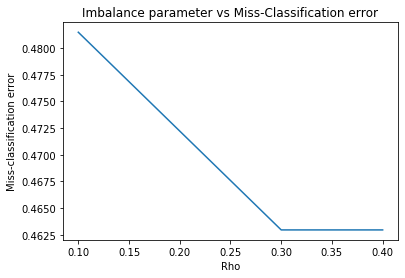

In [21]:
# Plot misclassification curve
plt.plot(rhos, errors)
plt.xlabel('Rho')

plt.ylabel('Miss-classification error')

plt.title('Imbalance parameter vs Miss-Classification error')
plt.show()

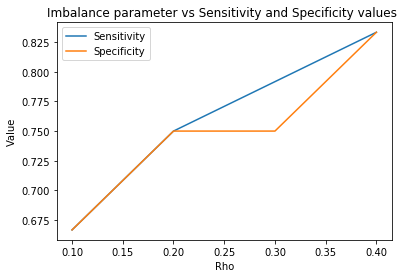

In [22]:
# Plot the curves of Sensitivity and Specificity together

plt.plot(rhos, sens, label = "Sensitivity")

plt.plot(rhos, spec, label = "Specificity")

plt.xlabel('Rho')

plt.ylabel('Value')

plt.title('Imbalance parameter vs Sensitivity and Specificity values ')
plt.legend()

plt.show()

In [23]:
# Implementing Linear SVM with multiple rho and Lambda values on Validation set
from sklearn.metrics import roc_auc_score

best_roc, best_lambda, best_rho = 0, 0, 0
best_beta = np.zeros((len(X_train),1))
for Lambda in range(1, 11):
  for rho in range(1, 11):
    eps = 0.005
    beta = np.zeros((len(X_train),1))
    theta = np.zeros((len(X_train),1))
    step = np.reciprocal(Lestimate(X_train, 0.5))
    final_beta, all_betas_fast, iters_fast = mylinearsvm(X_train, y_train, L/10, beta, theta, eps, step,  rho/10)

    ## mylinearsvm(X, y, Lambda, beta, theta, epsilon, step, rho):
    roc_val = roc_auc_score(y_val, np.sign(X_val.T.dot(final_beta)))
    if roc_val > best_roc:
      best_roc = roc_val
      best_lambda = Lambda/10
      best_rho = rho/10
      best_beta = final_beta

3.2664986902656277
Iteration:  1 Objective:  1.0370916607025147
2.964490618747218
Iteration:  2 Objective:  1.1877211435603834
2.3183268448630265
Iteration:  3 Objective:  1.4523792204330346
1.9628548936052652
Iteration:  4 Objective:  1.824859057866389
1.7216620155545475
Iteration:  5 Objective:  2.293739547941816
1.315091372479247
Iteration:  6 Objective:  2.8613103848102863
1.0742514081709724
Iteration:  7 Objective:  3.5093535301125467
0.9594156415984811
Iteration:  8 Objective:  4.233394586894528
0.8364966614562606
Iteration:  9 Objective:  5.0267191564651625
0.7283690849178709
Iteration:  10 Objective:  5.850068573010725
0.5188938610577638
Iteration:  11 Objective:  6.653884508102306
0.3287412147634179
Iteration:  12 Objective:  7.427932679697186
0.2532729405451757
Iteration:  13 Objective:  8.161323675895602
0.18784318900429975
Iteration:  14 Objective:  8.843297886972328
0.13240813565976786
Iteration:  15 Objective:  9.464366922215934
0.08796150514405206
Iteration:  16 Objectiv

Iteration:  28 Objective:  13.171276689705302
0.05234979575258318
Iteration:  29 Objective:  12.982374920595264
0.04171950845297419
Iteration:  30 Objective:  12.790803338876295
0.031972233231819615
Iteration:  31 Objective:  12.604120270702913
0.02409176398332527
Iteration:  32 Objective:  12.428591480887896
0.019482983102115416
Iteration:  33 Objective:  12.269186865541322
0.01907559924791385
Iteration:  34 Objective:  12.129616891514907
0.021647890037556856
Iteration:  35 Objective:  12.012369425633931
0.025142890177875417
Iteration:  36 Objective:  11.918863508405146
0.028239132917812222
Iteration:  37 Objective:  11.849556960750814
0.030411688989881554
Iteration:  38 Objective:  11.804061140565985
0.031481837046551095
Iteration:  39 Objective:  11.781257545001127
0.03143946595513319
Iteration:  40 Objective:  11.77941442055994
0.03036729714395671
Iteration:  41 Objective:  11.796302228143695
0.028405074056431667
Iteration:  42 Objective:  11.829307500846246
0.025730427785276986
It

Iteration:  39 Objective:  14.089099075087569
0.030407753645206995
Iteration:  40 Objective:  14.07379984365159
0.03056052521337264
Iteration:  41 Objective:  14.083192377433448
0.02958488107653206
Iteration:  42 Objective:  14.114266023400203
0.027632351166883957
Iteration:  43 Objective:  14.163587057645683
0.02488463277257327
Iteration:  44 Objective:  14.22744029124692
0.021544570585616468
Iteration:  45 Objective:  14.30196739060893
0.017832726570246125
Iteration:  46 Objective:  14.383300303051662
0.013994823050445587
Iteration:  47 Objective:  14.467687448944108
0.01033887261906989
Iteration:  48 Objective:  14.55160974628076
0.007358388906426069
Iteration:  49 Objective:  14.631883208990645
0.005931736372563575
Iteration:  50 Objective:  14.705744885976118
0.006592413607041946
Iteration:  51 Objective:  14.770919303030027
0.008365000840938788
Iteration:  52 Objective:  14.825663298290035
0.010247025789349124
Iteration:  53 Objective:  14.868788124010058
0.011815306677642691
Ite

Iteration:  48 Objective:  17.18416798987697
0.005565861664768188
Iteration:  49 Objective:  17.278438658811645
0.005674448054435589
Iteration:  50 Objective:  17.363662647764034
0.0075620185232478515
Iteration:  51 Objective:  17.43736847355762
0.00975407352985804
Iteration:  52 Objective:  17.497743079949043
0.011646540046452753
Iteration:  53 Objective:  17.543646078849935
0.013039251803204236
Iteration:  54 Objective:  17.574597064401615
0.013867087946421636
Iteration:  55 Objective:  17.590737975545768
0.014125108041867467
Iteration:  56 Objective:  17.592773689926076
0.013843910429974715
Iteration:  57 Objective:  17.581894978060983
0.01307867801904884
Iteration:  58 Objective:  17.559688567017382
0.011902750156243919
Iteration:  59 Objective:  17.528039332461407
0.010403362524825542
Iteration:  60 Objective:  17.48902956973522
0.008679601780869593
Iteration:  61 Objective:  17.444839932360612
0.006844991631815316
Iteration:  62 Objective:  17.397656035757777
0.005043765434352749

Iteration:  47 Objective:  19.671256822500467
0.013859812928785221
Iteration:  48 Objective:  19.79777356403721
0.009323497661262116
Iteration:  49 Objective:  19.921385249973536
0.00546404030421951
Iteration:  50 Objective:  20.03760022409518
3.453033508457871
Iteration:  1 Objective:  1.0337904308831525
2.630633275828666
Iteration:  2 Objective:  1.2623755422406187
1.7227778723070502
Iteration:  3 Objective:  1.667962117019059
1.6203391099814326
Iteration:  4 Objective:  2.256991615186286
1.3815158380500587
Iteration:  5 Objective:  3.0476571778847363
1.149274958744427
Iteration:  6 Objective:  4.013496636603539
1.0471702829783593
Iteration:  7 Objective:  5.124836429652128
0.8267877728592031
Iteration:  8 Objective:  6.381724886159132
0.7312002472212156
Iteration:  9 Objective:  7.77203501096192
0.6378612927986981
Iteration:  10 Objective:  9.273855979166683
0.547810468803035
Iteration:  11 Objective:  10.85770194831082
0.46131323802426666
Iteration:  12 Objective:  12.4889936145746

Iteration:  41 Objective:  10.910121181347632
0.01748931300653014
Iteration:  42 Objective:  10.958431390296898
0.017948860572351844
Iteration:  43 Objective:  11.008211872137586
0.019046637726102433
Iteration:  44 Objective:  11.057456934952208
0.020227020104716126
Iteration:  45 Objective:  11.104373519336797
0.02112480953900639
Iteration:  46 Objective:  11.147423543211588
0.02154439211134347
Iteration:  47 Objective:  11.18535511790324
0.021407126309319017
Iteration:  48 Objective:  11.21722191718314
0.02071196508839592
Iteration:  49 Objective:  11.242390473676537
0.01951098602650216
Iteration:  50 Objective:  11.260535710544103
0.01789474076492371
Iteration:  51 Objective:  11.271625540425795
0.01598409924189727
Iteration:  52 Objective:  11.275895832411342
0.013927433697992278
Iteration:  53 Objective:  11.273817424354512
0.011902970582753464
Iteration:  54 Objective:  11.266057117369652
0.010123252665859664
Iteration:  55 Objective:  11.253434720411839
0.008823515351409808
Iter

Iteration:  51 Objective:  13.545428920734455
0.009572591470385037
Iteration:  52 Objective:  13.59273353230523
0.011207125514400118
Iteration:  53 Objective:  13.62934598326488
0.012497162363082959
Iteration:  54 Objective:  13.65480531326423
0.013321821663958733
Iteration:  55 Objective:  13.66912353250387
0.013645428793915818
Iteration:  56 Objective:  13.672744375646406
0.0134793098039653
Iteration:  57 Objective:  13.666488186014137
0.01286510702552118
Iteration:  58 Objective:  13.651486396234953
0.011866071196341779
Iteration:  59 Objective:  13.629109325870287
0.010562050194387329
Iteration:  60 Objective:  13.600891016934048
0.009047395014810833
Iteration:  61 Objective:  13.568454602526028
0.0074333291591347226
Iteration:  62 Objective:  13.533441297613253
0.0058598770719595576
Iteration:  63 Objective:  13.497445569874783
3.338971837999791
Iteration:  1 Objective:  1.0356542971401437
2.9133148029937663
Iteration:  2 Objective:  1.2161943149331946
1.976971897625206
Iteration:

Iteration:  5 Objective:  2.7644794691395393
1.2382635696150295
Iteration:  6 Objective:  3.5755941335041372
1.0278784551753235
Iteration:  7 Objective:  4.509819243877254
0.841714983730268
Iteration:  8 Objective:  5.566495706444844
0.7129020544770727
Iteration:  9 Objective:  6.719570402014992
0.5878125205937094
Iteration:  10 Objective:  7.945336281047922
0.5003053402491183
Iteration:  11 Objective:  9.221732096513662
0.4178990111583069
Iteration:  12 Objective:  10.522727439428252
0.3406658545679553
Iteration:  13 Objective:  11.811826192200524
0.2564908621441816
Iteration:  14 Objective:  13.061029126188533
0.19236557379915661
Iteration:  15 Objective:  14.243473440074865
0.1352234846979093
Iteration:  16 Objective:  15.335090865207196
0.0858298572000638
Iteration:  17 Objective:  16.31578183024517
0.04614587154633988
Iteration:  18 Objective:  17.170255178543773
0.026493501281995988
Iteration:  19 Objective:  17.888585202844574
0.039054259931262755
Iteration:  20 Objective:  18.4

Iteration:  8 Objective:  6.098666359553512
0.7214187989936797
Iteration:  9 Objective:  7.402829360997744
0.6190233408593615
Iteration:  10 Objective:  8.806099911029428
0.5305772609337837
Iteration:  11 Objective:  10.281423349926117
0.4460461016999041
Iteration:  12 Objective:  11.794456462589887
0.36190849031501654
Iteration:  13 Objective:  13.31077721894711
0.2874969149949459
Iteration:  14 Objective:  14.795051666601122
0.21915669670162463
Iteration:  15 Objective:  16.213157571810022
0.15756248646244944
Iteration:  16 Objective:  17.534108912020038
0.10331655523477942
Iteration:  17 Objective:  18.731660968556955
0.05724125795750121
Iteration:  18 Objective:  19.781655365695634
0.022227251381808
Iteration:  19 Objective:  20.67037623701588
0.03381959448191113
Iteration:  20 Objective:  21.39069765496841
0.05687451446258343
Iteration:  21 Objective:  21.941906571031485
0.07553755608990984
Iteration:  22 Objective:  22.329183607336542
0.08858912583734076
Iteration:  23 Objective:

Iteration:  10 Objective:  6.195379484587136
0.46724336232711755
Iteration:  11 Objective:  7.075003932281176
0.3381564050866805
Iteration:  12 Objective:  7.93114579369804
0.26304464010034007
Iteration:  13 Objective:  8.750169173819316
0.19729963973938372
Iteration:  14 Objective:  9.51882958970437
0.14080801698172427
Iteration:  15 Objective:  10.225395656008015
0.0942570327455211
Iteration:  16 Objective:  10.83904491273496
0.07615542880672806
Iteration:  17 Objective:  11.355501266030682
0.08153059774971255
Iteration:  18 Objective:  11.773545048516047
0.09193486901447877
Iteration:  19 Objective:  12.094864476816806
0.10113647242456043
Iteration:  20 Objective:  12.323759681568081
0.106835704792464
Iteration:  21 Objective:  12.466899414823342
0.10862664961299552
Iteration:  22 Objective:  12.532843689347366
0.10667989547328635
Iteration:  23 Objective:  12.531520603886946
0.10147117197381851
Iteration:  24 Objective:  12.473699416159544
0.0936099703794944
Iteration:  25 Objectiv

Iteration:  22 Objective:  14.980787585021783
0.09170351612567108
Iteration:  23 Objective:  15.055099279691726
0.09233676360410903
Iteration:  24 Objective:  15.05173793192849
0.08957873688381332
Iteration:  25 Objective:  14.982862459358854
0.08398314760739856
Iteration:  26 Objective:  14.86117941666116
0.07615131589936433
Iteration:  27 Objective:  14.69939099697034
0.06669827970754522
Iteration:  28 Objective:  14.509724167911951
0.05623662959706846
Iteration:  29 Objective:  14.303553517391387
0.04537759425561461
Iteration:  30 Objective:  14.091121492227428
0.03476427314909776
Iteration:  31 Objective:  13.88135227896948
0.025189795551405016
Iteration:  32 Objective:  13.681750009048928
0.01793294884177745
Iteration:  33 Objective:  13.498368423003605
0.01503099801055859
Iteration:  34 Objective:  13.335837522725088
0.01695160206323978
Iteration:  35 Objective:  13.197432812499683
0.020993940455200047
Iteration:  36 Objective:  13.085174088373819
0.025011839578062585
Iteration: 

Iteration:  25 Objective:  17.87289977264536
0.0884421714592413
Iteration:  26 Objective:  17.75317816762604
0.08231740203035355
Iteration:  27 Objective:  17.57708009872295
0.07394157298487408
Iteration:  28 Objective:  17.35981535150044
0.06394645759180007
Iteration:  29 Objective:  17.115805135138448
0.05294766944930767
Iteration:  30 Objective:  16.858267777385336
0.04154465097243772
Iteration:  31 Objective:  16.59895944904515
0.030359033591613235
Iteration:  32 Objective:  16.34797422034569
0.0202003761608541
Iteration:  33 Objective:  16.113627610113706
0.012701217695916258
Iteration:  34 Objective:  15.90244827774533
0.011382977246818504
Iteration:  35 Objective:  15.719238826596122
0.015699688775524887
Iteration:  36 Objective:  15.567192379116877
0.021045163891066778
Iteration:  37 Objective:  15.448028115625316
0.025614894376734972
Iteration:  38 Objective:  15.362144109362884
0.028932236485697902
Iteration:  39 Objective:  15.308778881959528
0.030883960273746663
Iteration: 

Iteration:  32 Objective:  19.037403641453054
0.021819754219426623
Iteration:  33 Objective:  18.750923426241147
0.011241746404202592
Iteration:  34 Objective:  18.497911018044164
0.01600060532767726
Iteration:  35 Objective:  18.283283899761443
0.022563831906805273
Iteration:  36 Objective:  18.110000335992808
0.028261944641017098
Iteration:  37 Objective:  17.979254308507574
0.03248180139601002
Iteration:  38 Objective:  17.89068319352721
0.0350861616962885
Iteration:  39 Objective:  17.842579725325866
0.03610288202408115
Iteration:  40 Objective:  17.832102172943436
0.03564554861236661
Iteration:  41 Objective:  17.855480837837497
0.03388248296058071
Iteration:  42 Objective:  17.908220534451317
0.03101912452085276
Iteration:  43 Objective:  17.98529931802592
0.02728560963997862
Iteration:  44 Objective:  18.081363429724465
0.022927971571305387
Iteration:  45 Objective:  18.1909175047214
0.018204842517681435
Iteration:  46 Objective:  18.308508473189
0.013396009780441084
Iteration: 

KeyboardInterrupt: 

In [ ]:
y_test.shape
X_test.shape
best_beta.shape

In [ ]:
print("Best value of Lambda and Rho: ", best_lambda, best_rho)
cm = confusion_matrix(y_test, np.sign(X_test.T.dot(best_beta)))

sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
print('Sensitivity : ', sensitivity )

specificity = cm[1,1]/(cm[1,0]+cm[1,1])
print('Specificity : ', specificity)

In [ ]:
print("Best value of Lambda and Rho: ", best_lambda, best_rho)
cm = confusion_matrix(y_test, np.sign(X_test.T.dot(best_beta)))

sensitivity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity )

specificity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity)
